## 4.5 编码器与解码器架构

语言模型是自然语言处理的关键， 而**机器翻译**是语言模型最成功的基准测试。 因为机器翻译正是将输入序列转换成输出序列的序列转换模型（sequence transduction）的核心问题。 下面我们引入新的机器翻译(英语翻法语)数据集来讲解编码器与解码器架构

In [2]:
import os
import torch
from d2l import torch as d2l
from torch import nn

### 4.5.1 机器翻译与数据集

首先我们下载(英语 --> 法语)数据集:

In [8]:
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip', '94646ad1522d915e7b0f9296181140edcf86a4f5')

def read_data_nmt():
    """载入“英语－法语”数据集"""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r',
              encoding='utf-8') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !




* 文本预处理

原始文本数据需要经过几个简单**预处理**步骤:
1. 标点符号前面空格。
2. 我们用空格代替不间断空格（non-breaking space）。
3. 使用小写字母替换大写字母，并在单词和标点符号之间插入空格。

In [4]:
def preprocess_nmt(text):
    """预处理“英语－法语”数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' ' # 标点前面空格

    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()   # 半角全角空格全部变成单个空格
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


* 词元化

机器翻译中，我们更喜欢**单词级词元化**: （最先进的模型可能使用更高级的词元化技术）。

1. `tokenize_nmt`函数对前`num_examples`个文本序列对进行词元， 其中每个词元要么是一个词，要么是一个标点符号。

2. 此函数返回两个词元列表：`source`和`target`： `source[i]`是源语言（这里是英语）第i个文本序列的词元列表， `target[i]`是目标语言（这里是法语）第i个文本序列的词元列表。

In [9]:
def tokenize_nmt(text, num_examples=None):
    """词元化“英语－法语”数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

* 可视化

绘制每个文本序列所包含的词元数量的直方图。 在这个简单的“英－法”数据集中，大多数文本序列的词元数量少于20个。

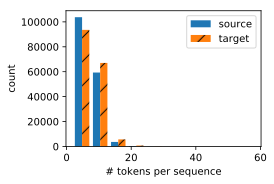

In [10]:
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """绘制列表长度对的直方图"""
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)

show_list_len_pair_hist(['source', 'target'], '# tokens per sequence', 'count', source, target);

* **构建词汇表**

由于机器翻译数据集由语言对组成， 因此我们可以分别为源语言和目标语言构建两个词表。


使用单词级词元化时，词表大小将明显*大于*使用字符级词元化时的词表大小。 为了缓解这一问题，这里我们将:

* 出现次数少于2次的低频率词元 视为相同的未知（`<unk>`）词元。
* 小批量时用于将序列填充到相同长度的填充词元（`<pad>`）。
* 序列的开始词元（`<bos>`）。
* 结束词元（`<eos>`）。

上述这些特殊词元在NLP的众多任务中都非常常见！

In [11]:
src_vocab = d2l.Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

* 截断文本序列

下面的`truncate_pad`函数将根据序列文本的固定长度截断或填充文本序列。

当然目前有分片的技术可以避免文本截断，感兴趣的读者可以自行了解

In [12]:
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

* 小批量数据集训练

In [13]:
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]  # 每个句子结束为eos
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)  # 实际上有多长，不算入padding
    return array, valid_len

* 载入数据集

In [14]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

下面我们读出“英语－法语”数据集中的第一个小批量数据：

In [15]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))·
    print('X的有效长度:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break

X: tensor([[10, 73,  4,  3,  1,  1,  1,  1],
        [99, 12,  4,  3,  1,  1,  1,  1]], dtype=torch.int32)
X的有效长度: tensor([4, 4])
Y: tensor([[8, 0, 4, 3, 1, 1, 1, 1],
        [0, 4, 3, 1, 1, 1, 1, 1]], dtype=torch.int32)
Y的有效长度: tensor([4, 3])


### 4.5.2 Encoder-Decoder 架构

首先在讲解编码器解码器之前，我们对`CNN`进行重新的观察, 我们把`CNN`也理解为一个`encode`和`decode`的过程，其示意图如下所示:

![image-20220209162714848](https://s2.loli.net/2022/02/09/TQ7A2mYlc1e9hjo.png)


可以观察到：
* 编码器（encoder）:将输入编程成中间表达形式(特征)
  * 将文本表示成向量
* 解码器（decoder）:将中间表示解码成输出
  * 向量表示成输出

![image-20220209162907917](https://s2.loli.net/2022/02/09/7rPTW2kvnxFiBSR.png)


而在这里，我们要介绍的编码器-解码器架构如下（一个模型分成**两块**）:
* 编码器处理输入
* 解码器处理输出

![../_images/encoder-decoder.svg](https://zh-v2.d2l.ai/_images/encoder-decoder.svg)

下面进行代码实践。

* 编码器

In [17]:
class Encoder(nn.Module):
    """编码器-解码器结构的基本编码器接口"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

* 解码器

有一个初始状态，编码器的东西要传给它

In [19]:
class Decoder(nn.Module):
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

* 合并架构

总而言之，“编码器-解码器”架构包含了一个编码器和一个解码器， 并且还拥有可选的额外的参数。 在前向传播中，编码器的输出用于生成编码状态， 这个状态又被解码器作为其**输入**的一部分。

In [ ]:
class EncoderDecoder(nn.Module):
    """编码器-解码器架构的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

可以看到我们这里只是简单写出了`encoder-decoder`的基类，在后面小节我们将再深入说说他是如何使用的。